In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport
import src.dataHandling.cleaningUtils as clean
import os
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


In [2]:
def drop_irrelevant(df: pd.DataFrame) -> pd.DataFrame:
    """
    drops columns which are irrelevant for the model (mostly ids)
    :param df: pd.DataFrame
    :return: None
    """
    irrelevant_cols = []
    general_irrelevant = ['gameDuration', 'gameCreation', 'gameVersion', 'mapId', 'queueId', 'patch', 'seasonId',
                          'platformId']
    irrelevant_cols.extend(general_irrelevant)
    participant_irrelevant = ['win', 'lp']
    for i in range(1, 11):
        for col in participant_irrelevant:
            irrelevant_cols.append(f'participant{i}_{col}')
    df_new = df.drop(columns=irrelevant_cols)
    return df_new

In [3]:
try:
    with open("data/static_05_12_23/raw/static_full.pkl", "rb") as f:
        df = pickle.load(f)
except FileNotFoundError:
    os.chdir('../')
    with open("data/static_05_12_23/raw/static_full.pkl", "rb") as f:
        df = pickle.load(f)
df = clean.drop_wrong_data(df)
df.reset_index(drop=True, inplace=True)
df = clean.fix_rank(df)
df = clean.calc_winrate(df)
df = clean.fix_teamId(df)
df = clean.convert_booleans(df)
df = clean.convert_lastPlayTime(df)
df = clean.convert_championTier(df)
df = clean.get_winning_team(df)  # this has to be the last step where a column is inserted
df = clean.drop_wrong_teamIds(df)
df = drop_irrelevant(df)
df = clean.drop_missing(df)
assert df.columns[-1] == 'label'
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                    df.iloc[:, -1],
                                                    test_size=0.1,
                                                    random_state=42,
                                                    shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.1,
                                                  random_state=42,
                                                  shuffle=True)

found 51360 rows
dropped wrong mapId
dropped wrong queueId
dropped wrong gameDuration
dropped wrong seasonId
dropped wrong gameVersion
dropped wrong patch
dropped 0 wrong rows
dropped 51 rows because of wrong teamIds
dropped 25835 rows


In [4]:
len(df)

25474

In [5]:
df.head()

,participant1_level,participant1_champion_championNumber,participant1_champion_infoAttack,participant1_champion_infoDefense,participant1_champion_infoMagic,participant1_champion_infoDifficulty,participant1_champion_tier,participant1_champion_win_rate,participant1_champion_pick_rate,participant1_champion_ban_rate,...,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate,label
3,841,54,5,9,7,2,5,51.50,15.2,15.2,...,0.541528,0.524000,0.653846,0.511971,0.506912,0.553476,0.525275,0.468750,0.508163,1
4,766,24,7,5,7,5,0,48.49,16.8,16.8,...,0.517751,0.536443,0.504360,0.562264,0.368421,0.666667,0.428571,0.583333,0.622449,0
7,188,54,5,9,7,2,5,51.50,15.2,15.2,...,0.513274,0.528000,0.515038,0.504274,0.505882,0.529586,1.000000,0.519846,0.539648,0
8,54,24,7,5,7,5,0,48.49,16.8,16.8,...,0.510870,0.562189,0.508333,0.555556,0.552239,0.541528,0.538462,0.457143,0.568182,0
10,54,24,7,5,7,5,0,48.49,16.8,16.8,...,0.538462,0.534591,0.505263,0.554545,0.489130,0.342857,0.529049,0.777778,0.524194,0


In [6]:
kda_columns = ['participant1_champion_kda', 'participant2_champion_kda', 'participant3_champion_kda',
               'participant4_champion_kda', 'participant5_champion_kda', 'participant6_champion_kda',
               'participant7_champion_kda', 'participant8_champion_kda', 'participant9_champion_kda',
               'participant10_champion_kda']


In [7]:
corr_pearson = df.corr()
corr_pearson_target = abs(corr_pearson["label"])
relevant_features = corr_pearson_target[corr_pearson_target > 0.05]
corr_pearson_target.sort_values(ascending=False)


label                     1.000000
participant5_kda          0.148490
participant4_kda          0.147304
participant9_kda          0.141731
participant10_kda         0.137244
                            ...   
participant8_teamId            NaN
participant9_inactive          NaN
participant9_teamId            NaN
participant10_inactive         NaN
participant10_teamId           NaN
Name: label, Length: 321, dtype: float64

In [8]:
from scipy.stats import pearsonr

# Assuming df is your DataFrame
results = []
for column in df.columns:
    if column != 'label':  # Replace 'target_column' with your target column name
        corr, pval = pearsonr(df[column], df['label'])
        results.append({'Feature': column, 'Correlation': corr, 'P-Value': pval})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Correlation', ascending=False, key=abs)

An input array is constant; the correlation coefficient is not defined.


In [9]:
results_df

,Feature,Correlation,P-Value
146,participant5_kda,-0.148490,1.599941e-125
115,participant4_kda,-0.147304,1.550305e-123
270,participant9_kda,0.141731,2.025986e-114
301,participant10_kda,0.137244,2.411086e-107
208,participant7_kda,0.133492,1.312715e-101
...,...,...,...
247,participant8_teamId,NaN,NaN
262,participant9_inactive,NaN,NaN
278,participant9_teamId,NaN,NaN
293,participant10_inactive,NaN,NaN


In [10]:
results_df['Correlation'] = results_df['Correlation'].abs().sort_values(ascending=False)

In [11]:
results_df['category'] = results_df['Feature'].str.extract(r'(participant\d+)_champion_(\w+)', expand=False)[1]
results_df

,Feature,Correlation,P-Value,category
146,participant5_kda,0.148490,1.599941e-125,NaN
115,participant4_kda,0.147304,1.550305e-123,NaN
270,participant9_kda,0.141731,2.025986e-114,NaN
301,participant10_kda,0.137244,2.411086e-107,NaN
208,participant7_kda,0.133492,1.312715e-101,NaN
...,...,...,...,...
247,participant8_teamId,NaN,NaN,NaN
262,participant9_inactive,NaN,NaN,NaN
278,participant9_teamId,NaN,NaN,NaN
293,participant10_inactive,NaN,NaN,NaN


In [12]:
average_per_category = results_df.groupby('category').mean()
average_per_category.sort_values(by='Correlation', ascending=False)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,Correlation,P-Value
category,,
win_rate,0.021424,0.004825
tier,0.017078,0.037595
ban_rate,0.009929,0.230711
pick_rate,0.009929,0.230711
championNumber,0.009876,0.268177
infoDefense,0.008044,0.331976
infoMagic,0.007696,0.384729
infoAttack,0.007429,0.414074
matches,0.005034,0.497702


In [13]:
bst = xgb.XGBClassifier(n_estimators=100, max_depth=30, learning_rate=0.1, objective='binary:logistic', device='cpu')

In [14]:
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
bst.score(X_test, y_test)

0.7021193092621664

In [16]:
feature_important = bst.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=False)
data

,score
participant4_kda,834.0
participant3_kda,796.0
participant8_kda,780.0
participant2_kda,778.0
participant9_kda,771.0
...,...
participant9_veteran,27.0
participant2_veteran,25.0
participant3_veteran,23.0
participant1_veteran,21.0


In [17]:
data_reset = data.reset_index()
data_reset['category'] = data_reset['index'].str.extract(r'(participant\d+)_champion_(\w+)', expand=False)[1]
average_per_category = data_reset.groupby('category').mean()
average_per_category.sort_values(by='score', ascending=False)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,score
category,
championNumber,323.9
matches,300.4
win_rate,268.8
pick_rate,268.5
infoAttack,124.7
infoDifficulty,123.6
infoMagic,119.6
infoDefense,105.9
tier,73.5


In [18]:
X_train.columns.values

array(['participant1_level', 'participant1_champion_championNumber',
       'participant1_champion_infoAttack',
       'participant1_champion_infoDefense',
       'participant1_champion_infoMagic',
       'participant1_champion_infoDifficulty',
       'participant1_champion_tier', 'participant1_champion_win_rate',
       'participant1_champion_pick_rate',
       'participant1_champion_ban_rate', 'participant1_champion_matches',
       'participant1_tier', 'participant1_leaguePoints',
       'participant1_veteran', 'participant1_inactive',
       'participant1_freshBlood', 'participant1_hotStreak',
       'participant1_lastPlayTime', 'participant1_championLevel',
       'participant1_championPoints',
       'participant1_championPointsSinceLastLevel',
       'participant1_tokensEarned', 'participant1_kda',
       'participant1_kills', 'participant1_deaths',
       'participant1_assists', 'participant1_maxKills', 'participant1_cs',
       'participant1_damage', 'participant1_gold', 'part

In [19]:
sortedidx = bst.feature_importances_.argsort()
X_train.columns.values[sortedidx]

array(['participant4_inactive', 'participant10_champion_ban_rate',
       'participant4_teamId', 'participant1_teamId',
       'participant6_teamId', 'participant9_teamId',
       'participant8_inactive', 'participant3_inactive',
       'participant2_teamId', 'participant2_champion_ban_rate',
       'participant7_teamId', 'participant9_inactive',
       'participant4_champion_ban_rate', 'participant2_inactive',
       'participant7_champion_ban_rate', 'participant8_teamId',
       'participant9_champion_ban_rate', 'participant3_teamId',
       'participant6_inactive', 'participant10_inactive',
       'participant7_inactive', 'participant6_champion_ban_rate',
       'participant5_champion_ban_rate', 'participant5_teamId',
       'participant8_champion_ban_rate', 'participant3_champion_ban_rate',
       'participant5_inactive', 'participant1_inactive',
       'participant1_champion_ban_rate', 'participant10_teamId',
       'participant6_veteran', 'participant5_tokensEarned',
       'part

In [20]:
bst.feature_importances_[sortedidx]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00175922, 0.00212892, 0.0021581 , 0.00226201, 0.0022928 ,
       0.00238556, 0.00239144, 0.00240375, 0.00241958, 0.00242656,
       0.00242687, 0.00250973, 0.00251921, 0.00253145, 0.00255477,
       0.00258612, 0.00258831, 0.00261614, 0.00263457, 0.00264515,
       0.00264582, 0.00265288, 0.00265815, 0.00268729, 0.00269053,
       0.00269535, 0.00270491, 0.00271338, 0.00271978, 0.00275116,
       0.00275174, 0.00275684, 0.00275725, 0.00276517, 0.00276593,
       0.00276826, 0.00277345, 0.00277887, 0.00278069, 0.00278228,
       0.00278699, 0.00278771, 0.00279044, 0.00279469, 0.00280

FixedFormatter should only be used together with FixedLocator


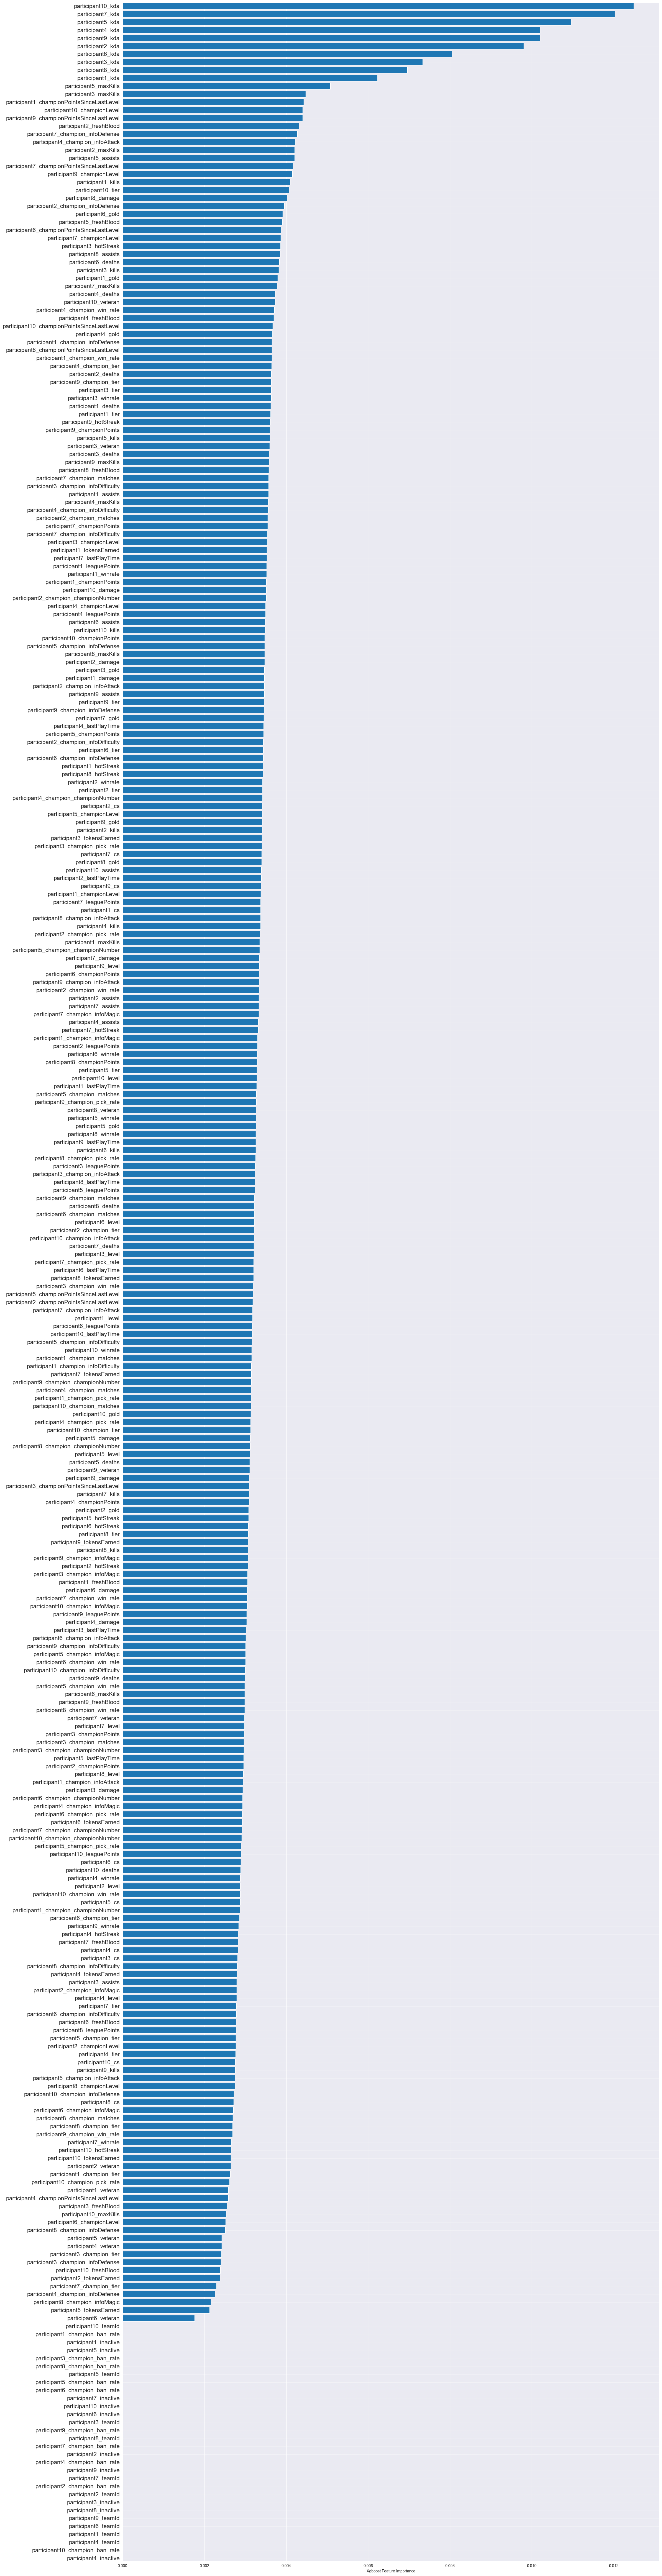

In [21]:
sorted_idx = bst.feature_importances_.argsort()
fig, ax = plt.subplots(figsize=(25, 120))
ax.set_yticklabels(X_train.columns.values[sorted_idx], fontsize=15)
ax.margins(y=0)
plt.barh(X_train.columns.values[sorted_idx], bst.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [22]:
X_train.columns.values[sorted_idx].tolist()[0:20]

['participant4_inactive',
 'participant10_champion_ban_rate',
 'participant4_teamId',
 'participant1_teamId',
 'participant6_teamId',
 'participant9_teamId',
 'participant8_inactive',
 'participant3_inactive',
 'participant2_teamId',
 'participant2_champion_ban_rate',
 'participant7_teamId',
 'participant9_inactive',
 'participant4_champion_ban_rate',
 'participant2_inactive',
 'participant7_champion_ban_rate',
 'participant8_teamId',
 'participant9_champion_ban_rate',
 'participant3_teamId',
 'participant6_inactive',
 'participant10_inactive']

In [28]:
bst2 = xgb.XGBClassifier(n_estimators=100, max_depth=80, learning_rate=0.1, objective='binary:logistic', device='cpu')
bst2.fit(X_train[X_train.columns.values[sorted_idx].tolist()], y_train)
bst2.score(X_test[X_train.columns.values[sorted_idx].tolist()], y_test)

0.7044740973312402

In [29]:
num_round = 100
param = {
    "eta": 0.05,
    "max_depth": 10,
    "tree_method": "hist",
    "device": "cuda",
}

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.values.tolist())
model = xgb.train(param, dtrain, num_round)

In [ ]:
model.set_param({"device": "cuda"})
shap_values = model.predict(dtrain, pred_contribs=True)

In [ ]:
shap_interaction_values = model.predict(dtrain, pred_interactions=True)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_train.to_numpy()[0, :],
    feature_names=X_train.columns.values.tolist(),
    matplotlib=True,
)

In [ ]:
perm_importance = permutation_importance(bst, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(15, 105))
ax.set_yticklabels(X_train.columns.values[sorted_idx], fontsize=10)
ax.margins(y=0)
plt.barh(X_train.columns.values[sorted_idx], bst.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [ ]:
X_train[X_train.columns.values[sorted_idx][-1]]